In [5]:
# Word frequency analysis on the tokenized_description field
import re
from collections import Counter

# Combine all non-null tokenized descriptions into one string (convert to lowercase)
all_tokenized_text = " ".join(str(tdesc).lower() for tdesc in df["tokenized_description"] if pd.notnull(tdesc))

# Extract words using regex (alphanumeric characters)
words = re.findall(r'\b\w+\b', all_tokenized_text)

# Count the frequency of each word
word_counts = Counter(words)

# Get the top 100 most common words
top_100 = word_counts.most_common(100)

# Print the results
print("\nTop 100 most common words in the 'tokenized_description' field:")
for word, count in top_100:
    print(f"{word}: {count}")


Top 100 most common words in the 'tokenized_description' field:
order: 855
thank: 529
delivery: 366
item: 264
good: 240
add: 189
case: 187
receive: 186
so: 185
morning: 166
email: 155
know: 144
schedule: 138
number: 137
cancel: 133
need: 131
pallet: 125
like: 124
date: 117
pick: 117
partner: 115
change: 114
available: 111
day: 110
food: 106
phone: 103
time: 102
let: 102
am: 98
produce: 96
possible: 90
th: 88
send: 85
week: 82
get: 81
help: 76
able: 76
last: 76
today: 75
pm: 73
make: 71
pickup: 70
request: 70
write: 68
distribution: 67
reach: 66
information: 66
remove: 65
afternoon: 65
question: 64
call: 64
hope: 64
regard: 64
box: 64
deliver: 62
well: 62
see: 62
assistance: 61
only: 60
want: 59
place: 58
sale: 58
use: 57
come: 57
message: 57
find: 57
limit: 57
window: 56
training: 56
hour: 55
try: 52
appreciate: 52
also: 52
just: 51
support: 51
tomorrow: 50
new: 50
pound: 50
ensure: 49
reschedule: 48
go: 47
tefap: 46
other: 45
system: 45
close: 44
driver: 44
exceed: 44
update: 43
edit

In [1]:
import pandas as pd
import json

# Load the CSV file
bert_df = pd.read_csv("bert_topic_info.csv")
tickets_df = pd.read_csv("tickets_with_subtopics.csv")
# Select only the 'topic' and 'name' columns
bert_df = bert_df[["Topic", "Name"]]
df = tickets_df[["Description", "Topic"]]


In [2]:
df

,Description,Topic
0,Sent email Friday to cancel order Yvonne Brown...,0
1,Can you please add 25 cases of the following t...,6
2,Please add the following to my order 35 cases ...,4
3,Good morning Can you please add the following ...,-1
4,The deadline on our grant for 309761 is May 27...,7
...,...,...
735,I would like to edit our order number for 56 C...,13
736,My orders saved as a credit card order rather ...,10
737,Could you please add whatever produce is avail...,6
738,Number 3016484884 Hello 7th Adventist Church j...,-1


In [3]:
import re
import pandas as pd

weighted_keywords = {
    "urgent": 3,
    "asap": 3,
    "immediately": 3,
    "critical": 3,
    "emergency": 3,
    "today": 3,
    "death": 3,
    "cancel": 2,
    "add": 2,
    "change": 2,
    "reschedule": 2,
    "edit": 2,
    "update": 2,
    "delete": 2,
    "missing": 2,
    "delay": 1,
    "tomorrow": 1,
    "now": 1,
    "problem": 1,
    "help": 1,
    "remove": 1,
    "assistance": 1,
    "support": 1,
    "issue": 1,
    "expire": 1,
    "move": 1
}

# --- Topic ID to priority label mapping ---
category_priority_map = {
    -1: "High",     # -1_items_order_order items_items customer
    0: "High",      # 0_cancelation_delivery cancelation_cancelation customer_cancel
    1: "High",      # 1_partnerlink_administration_agency administration_agency
    2: "High",      # 2_missing_delivery pickup_missing item_pickup missing
    3: "Low",       # 3_menu_menu general_availability_inventory availability
    4: "High",      # 4_delivery edit_items customer_order items_edit order
    5: "Low",       # 5_pickup_pallet pickup_pickup pallet_pickup customer
    6: "High",      # 6_produce_request customer_produce request_delivery produce
    7: "Low",       # 7_grants_billing grants_billing_grant
    8: "Medium",    # 8_pickup general_delivery pickup_eta_status customer
    9: "High",      # 9_window customer_window_datetime_datetime change
    10: "High",     # 10_items_add items_items order_edit
    11: "High",     # 11_reschedule_change_change reschedule_reschedule customer
    12: "High",     # 12_vegetables_request customer_produce request_delivery produce
    13: "High",     # 13_edit_edit order_delivery edit_items customer
    14: "High",     # 14_cafb staff_administration connection_connection_connection cafb
    15: "High",     # 15_remove_wants remove_items_items customer
    16: "High",     # 16_reschedule_delivery datatime_datatime_datatime change
    17: "Medium",   # 17_delivery general_questions_general questions_general
    18: "High",     # 18_reschedule_weather_change reschedule_delivery datatime
    19: "High",     # 19_cancel order_wants cancel_cancel_cancelation customer
    20: "Low",      # 20_best_expiration_expiration date_product best
    21: "Low",      # 21_delivery report_report issue_issue_report
    22: "Low"       # 22_food_delivery general_general_questions
}

# --- Priority levels to numeric scores ---
priority_value_map = {
    "Low": 0,
    "Medium": 2,
    "High": 3
}

# --- Compute weighted keyword score from description ---
def compute_weighted_score(text, keywords):
    text = str(text).lower()
    return sum(len(re.findall(rf'\b{re.escape(word)}\b', text)) * weight
               for word, weight in keywords.items())

# --- Compute dynamic score from topic (request category) ---
def compute_dynamic_score(topic_id, priority_map, value_map):
    label = priority_map.get(topic_id)
    return value_map.get(label, 0)

# --- Hybrid scoring logic ---
def hybrid_priority_score(row, alpha=1.0, beta=1.0):
    description = row["Description"]
    topic = row["Topic"]
    weighted_score = compute_weighted_score(description, weighted_keywords)
    dynamic_score = compute_dynamic_score(topic, category_priority_map, priority_value_map)
    return (alpha * weighted_score) + (beta * dynamic_score)

# --- Assign final priority label from hybrid score ---
def assign_hybrid_priority(score):
    if score >= 3:
        return "High"
    elif score >= 1:
        return "Medium"
    else:
        return "Low"

# --- Run scoring on DataFrame ---
df["hybrid_score"] = df.apply(hybrid_priority_score, axis=1)
df["hybrid_priority"] = df["hybrid_score"].apply(assign_hybrid_priority)

# --- Output results ---
print("Hybrid Priority Distribution:")
print(df["hybrid_priority"].value_counts())



TypeError: hybrid_priority_score() missing 1 required positional argument: 'Topic'

In [13]:
import pandas as pd

# Ensure full text for descriptions
pd.set_option('display.max_colwidth', None)

# Allow display of more rows
pd.set_option('display.max_rows', 100)

# Filter DataFrame by priority
priority_filter = "Medium"  # Change to "Medium" or "Low" as needed
filtered_df = df[df['hybrid_priority'] == priority_filter]

# Reset index for better display (optional)
filtered_df = filtered_df.reset_index(drop=True)

# Show first 100 rows with full description and related info
filtered_df.loc[:99, ["Description", "Custom field (Request Category)", "hybrid_score", "hybrid_priority"]]



,Description,Custom field (Request Category),hybrid_score,hybrid_priority
0,The deadline on our grant FY24 MD Region MOCO 1H for 309761 is May 27 2024 When we tried to enter an order to use up that grant there were no delivery times available before May 27 because of the holiday weekend We spoke with Charity in Partner Support and she told us to submit our order with a May 28 delivery day and then email you to get the deadline extended by a day In addition to extending the deadline please have your finance department deduct the order from the above mentioned grant The computer automatically deducted it from our next MOCO grant which expires in June I apologize for causing you extra work Thank you for your assistance Dont hesitate to call if you have any questions Terry C phone number,Billing / Grants -> Grant Support,2.0,Medium
1,From Zoom Sent Tuesday May 21 2024 1237 PM To Thomas Britton Subject New Voicemail from GAIL HAYNIE 240 2106484 to Partner Support Ext 117423 on Tue May 21 2024 1236 4d1218949083,Orders - Pre delivery -> General Questions,1.0,Medium
2,Please call phone number regarding the change Esther Jordan Exec Dir AbsynaFeed,Orders - Pre delivery -> General Questions,2.0,Medium
3,Hello I submitted a payment on these invoices however they are still showing as pending When I tried to click on them I was instructed to contact you I would like to get the issue resolved as soon as possible so if someone would give me a call that would be great Thanks so much for your time 75 99519 7500,Billing / Grants -> Questions for Accounting,1.0,Medium
4,has exceed their Produce pound limit on their last Sales Order,Partner Produce Limit -> Overage Alert,2.0,Medium
5,has exceed their Produce pound limit on their last Sales Order,Partner Produce Limit -> Overage Alert,2.0,Medium
6,Would like to change pick up time to 10 am or 11 am Thanks,Orders - Pre delivery -> Date/Time Change - New window,2.0,Medium
7,Can you tell me the expiration dates on the donated items in my order There were many items without pictures so its difficult to know if they are appropriate for my site as well I dont know the weight or size of each item,Menu -> Product Best By / Expiration Date,2.0,Medium
8,Partner called Partner Support to ask that their two upcoming pickups are combined into one delivery order due to the total weight of the orders being larger than what they can accommodate Partner has a preferred delivery date of Friday due to their scheduled Saturday distribution I explained that with both orders being locked this may be difficult to accommodate as our delivery calendar is full until Monday 923 Escalated to for feedback before reaching out to Transportation and Ops Charity 917,Orders - Pre delivery -> Change to Pickup/vice versa,1.0,Medium
9,has exceed their Produce pound limit on their last Sales Order,Partner Produce Limit -> Overage Alert,2.0,Medium


In [14]:
print("Number of NaN in Description:", df["Description"].isna().sum())
print("Number of NaN in Request Category:", df["Custom field (Request Category)"].isna().sum())

# Show all rows where Description or Request Category is missing
nan_rows = df[df["Description"].isna() | df["Custom field (Request Category)"].isna()]

# Reset index for cleaner display (optional)
nan_rows = nan_rows.reset_index(drop=True)

# Display the full table (no truncation of text)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

# Show the rows
nan_rows

Number of NaN in Description: 172
Number of NaN in Request Category: 157


,Resolved,Custom field (Source),Comment,Comment.1,Comment.2,Comment.3,Comment.4,Comment.5,Comment.6,Comment.7,...,Comment.15,Comment.16,Comment.17,Comment.18,Comment.19,Comment.20,Priority,Cat_Priority,hybrid_score,hybrid_priority
0,04/26/2024 07:53,Portal,"07/10/2023 01:07;5fb17b020dd553006f17ff0a;Hi Darb,\n\nWe will look into this.",07/10/2023 01:07;5fb17b020dd553006f17ff0a;I think this needs to go to IT,07/10/2023 01:10;5fb29c170dd553006f224f06;h6. ðŸ³ï¸ Message originally posted in [IT-4689|https://capitalareafoodbank.atlassian.net/browse/IT-4689] on 10/Jul/2023 01:09 PM\n\nOK I will look,"07/10/2023 01:10;5fb29c170dd553006f224f06;h6. ðŸ³ï¸ Message originally posted in [IT-4689|https://capitalareafoodbank.atlassian.net/browse/IT-4689] on 10/Jul/2023 01:10 PM\n\nDarb,\n\nCan you tell us more",07/10/2023 01:11;qm:65d20c5a-0c84-458e-8ce1-adb90d07460f:19f932b4-b42f-4723-a915-05c76f1f5806;This is what is happeningâ€¦,"07/10/2023 01:21;5fb29c170dd553006f224f06;{quote}*[IT-4689]* ""Ticket From - Partner Support - SO-XXXXXX - TEST"" has been changed to a status of *Completed*\n----\nPlease check this issue for more details{quote}\n",07/10/2023 01:21;5fb29c170dd553006f224f06;h6. ðŸ³ï¸ Message originally posted in [IT-4689|https://capitalareafoodbank.atlassian.net/browse/IT-4689] on 10/Jul/2023 01:21 PM\n\nTHis is done,07/10/2023 01:22;5f05c9e30b38b10022652fe4;h6. ðŸ³ï¸ Message originally posted by [~accountid:557058:f58131cb-b67d-43c7-b30d-6b58d40bd077] in [IT-4689|https://capitalareafoodbank.atlassian.net/browse/IT-4689] on 10/Jul/2023 01:22 PM\n\nThe linked issue - [PART-4358] has been resolved,...,NaN,NaN,NaN,NaN,NaN,NaN,Low,Low,0.0,Low
1,04/26/2024 07:53,Email to Jira,04/26/2024 07:53;557058:f58131cb-b67d-43c7-b30d-6b58d40bd077;Ticket migrated to a new Jira Project. An automation set the Resolution field to Done. This updated the Resolved (a date) field to today's date. Prior to the migration the Resolve date was not used in metrics.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Low,Low,0.0,Low
2,04/26/2024 07:53,Portal,07/07/2023 06:59;5fb17b020dd553006f17ff0a;Working on it,07/07/2023 07:03;5fb17b020dd553006f17ff0a;This should get moved to ERP,"07/07/2023 07:03;5fb17b020dd553006f17ff0a;Hi Darb,\n\nWe have escalated your request to our internal team to look into the technical issue.\n\nThanks,\n\nBrad - Partner Support",07/07/2023 07:27;5fb29c170dd553006f224f06;h6. ðŸ³ï¸ Message originally posted in [IT-4676|https://capitalareafoodbank.atlassian.net/browse/IT-4676] on 07/Jul/2023 07:27 AM\n\nThanks for escalating to IT. We will check it out.,07/07/2023 07:32;5fb29c170dd553006f224f06;h6. ðŸ³ï¸ Message originally posted in [IT-4676|https://capitalareafoodbank.atlassian.net/browse/IT-4676] on 07/Jul/2023 07:31 AM\n\nThis is an internal note,07/12/2023 10:13;5f05c9e30b38b10022652fe4;h6. ðŸ³ï¸ Message originally posted by [~accountid:557058:f58131cb-b67d-43c7-b30d-6b58d40bd077] in [IT-4676|https://capitalareafoodbank.atlassian.net/browse/IT-4676] on 12/Jul/2023 10:13 AM\n\nThe linked issue - [PART-4341] has been resolved,04/26/2024 07:53;557058:f58131cb-b67d-43c7-b30d-6b58d40bd077;Ticket migrated to a new Jira Project. An automation set the Resolution field to Done. This updated the Resolved (a date) field to today's date. Prior to the migration the Resolve date was not used in metrics.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Low,Low,0.0,Low
3,04/26/2024 07:45,Portal,04/26/2024 07:45;557058:f58131cb-b67d-43c7-b30d-6b58d40bd077;Ticket migrated to a new Jira Project. An automation set the Resolution field to Done. This updated the Resolved (a date) field to today's date. Prior to the migration the Resolve date was not used in metrics.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Low,Low,0.0,Low
4,04/26/2024 08:09,Portal,"02/17/2022 03:30;6064f0c5d115550069adb87f;Good Afternoon\!\n\nYour estimated delivery window, is 12p-2pm.\n\nEnjoy the rest of your day\!","02/17/2022 03:32;qm:65d20c5a-0c84-458e-8ce1-adb90d

In [15]:
print("Number of 'has exceed their Produce pound limit on their last Sales Order':", (df["Description"]=="has exceed their Produce pound limit on their last Sales Order").sum())

Number of 'has exceed their Produce pound limit on their last Sales Order': 37


In [16]:
# Save the DataFrame with hybrid scores to a JSON file
df.to_json("df_with_hybrid_scores.json", orient="records", indent=4)


In [17]:
categories = ["Low", "Medium", "High"]

# Loop through each keyword and, for each priority category, count the occurrences
print("Occurrence of weighted keywords by priority:")
for word in weighted_keywords.keys():
    counts = {}
    for cat in categories:
        # Filter the DataFrame by priority and then sum up the occurrences of the word in each tokenized_description
        cat_count = df[df["hybrid_priority"] == cat]["tokenized_description"].dropna().apply(
            lambda x: len(re.findall(r'\b' + re.escape(word) + r'\b', x.lower()))
        ).sum()
        counts[cat] = cat_count
    print(f"{word}: Low = {counts['Low']}, Medium = {counts['Medium']}, High = {counts['High']}")

Occurrence of weighted keywords by priority:
urgent: Low = 0, Medium = 0, High = 1
asap: Low = 0, Medium = 0, High = 3
immediately: Low = 0, Medium = 0, High = 12
critical: Low = 0, Medium = 0, High = 2
emergency: Low = 0, Medium = 0, High = 2
today: Low = 0, Medium = 0, High = 75
death: Low = 0, Medium = 0, High = 1
cancel: Low = 2, Medium = 1, High = 130
add: Low = 2, Medium = 2, High = 185
change: Low = 3, Medium = 13, High = 98
reschedule: Low = 0, Medium = 2, High = 46
edit: Low = 0, Medium = 1, High = 40
update: Low = 0, Medium = 2, High = 41
delete: Low = 0, Medium = 0, High = 19
missing: Low = 0, Medium = 0, High = 5
delay: Low = 0, Medium = 1, High = 9
tomorrow: Low = 0, Medium = 4, High = 46
now: Low = 0, Medium = 2, High = 14
problem: Low = 0, Medium = 1, High = 18
help: Low = 1, Medium = 6, High = 69
remove: Low = 1, Medium = 1, High = 63
assistance: Low = 0, Medium = 6, High = 55
support: Low = 0, Medium = 3, High = 48
issue: Low = 1, Medium = 3, High = 36
expire: Low = 1,

In [18]:
# Filter rows where 'Description' contains 'change' and 'hybrid_priority' is 'Low'
low_priority_changes = df[(df['Description'].str.contains('add', case=False, na=False)) & (df['hybrid_priority'] == 'Low')]

# Print the descriptions
print("Low Priority Descriptions with 'change':")
for description in low_priority_changes['Description']:
    print(description)


Low Priority Descriptions with 'change':
Good afternoon Please we would like empty pallets from previous delivery picked up Please let us know if you need any additional information
Good afternoon Please we have some empty pallets from previous delivery to be picked up Please let me know if you need any additional information Thank you
Good Afternoon I was looking over my upcoming orders Somehow I did not place an order for 62824 I wanted to check and see if there was any way we could place an order This is the last week before we go on our summer vacation for two weeks and we wanted to be able to distribute that day Please let me know if we can be added Anytime slot would be greatly appreciated Oliver
We has added item 800020 Tomatoes 15 cases to the order but its not available when I tried saving the order This is one of our staple items Is it possible to get some Thanks
Good afternoon I just wanted to gain some clarification on the attached invoices starting with 157394 I purchased 

In [19]:
# Group by Request Category and count the occurrences of each priority level
category_priority_counts = df.groupby("Custom field (Request Category)")["hybrid_priority"].value_counts().unstack(fill_value=0)

print("Request Category Priority Distribution:")
ordered_columns = ['Low', 'Medium', 'High']
category_priority_counts = category_priority_counts.reindex(columns=ordered_columns)
print(category_priority_counts)

Request Category Priority Distribution:
hybrid_priority                                          Low  Medium  High
Custom field (Request Category)                                           
Agency Administration                                      3       1     0
Agency Administration -> Connection to CAFB Staff         11       4     5
Agency Administration -> Office Hours                      1       0     0
Agency Administration -> Partner Trainings                 0       0    19
Agency Administration -> Update Information                0      11     5
Billing / Grants -> Discrepancy in Invoice                 0       0     5
Billing / Grants -> General Questions                      0       3     4
Billing / Grants -> Grant Support                         10       3     1
Billing / Grants -> Questions for Accounting               4       3     0
Delivery / Pickup                                          2       0     0
Delivery / Pickup -> General Questions                     0

#LLAMA

In [20]:
from huggingface_hub import hf_hub_download

file_path = hf_hub_download(
    repo_id="TheBloke/Llama-2-7B-Chat-GGUF",
    filename="llama-2-7b-chat.Q4_K_M.gguf",
    local_dir="./models"
)

print("Model downloaded to:", file_path)



/Users/berkayyenilmez/.pyenv/versions/3.10.5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model downloaded to: models/llama-2-7b-chat.Q4_K_M.gguf


In [21]:
from llama_cpp import Llama

# Load your model with correct path and parameters
llm = Llama(
    model_path="/Users/berkayyenilmez/Desktop/GitHub/cafb_project/FOODTICKETAI/models/llama-2-7b-chat.Q4_K_M.gguf",  # adjust based on where you're running
    n_ctx=1024,
    n_threads=6,         # number of CPU threads (or experiment with this)
    n_gpu_layers=33      # offload all layers to GPU (for best Metal performance)
)

def predict_priority_with_llama(description, category=None):
    prompt = f"""
You are a smart support assistant. Classify the priority of the following support ticket as Low, Medium, or High.

Description: "{description}"
Request Category: "{category if category else 'None'}"

Respond with only one word: Low, Medium, or High.
Priority:"""

    output = llm(prompt, max_tokens=1, stop=["\n"])
    return output["choices"][0]["text"].strip()


llama_model_load_from_file_impl: using device Metal (Apple M2 Pro) - 10922 MiB free
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from /Users/berkayyenilmez/Desktop/GitHub/cafb_project/FOODTICKETAI/models/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:     

In [22]:
# Apply the logic to create labels for fine-tuning
df["llama_target_priority"] = df.apply(
    lambda row: assign_hybrid_priority(
        hybrid_priority_score(row, weighted_keywords, category_priority_map, priority_value_map)
    ),
    axis=1
)

# Drop rows with missing descriptions (required for LLM)
df_filtered = df[df["Description"].notna()].copy()

# Format as prompt-response pairs
df_filtered["prompt"] = df_filtered.apply(lambda row: f"""
You are a smart support assistant. Classify the priority of the following support ticket as Low, Medium, or High.

Description: \"{row['Description']}\"
Request Category: \"{row['Custom field (Request Category)'] if pd.notna(row['Custom field (Request Category)']) else 'None'}\"

Respond with only one word: Low, Medium, or High.
Priority:""", axis=1)

df_filtered["response"] = df_filtered["llama_target_priority"]

In [23]:
# Save in LLaMA fine-tuning format
import json

with open("llama_finetune_data.jsonl", "w") as f:
    for _, row in df_filtered.iterrows():
        f.write(json.dumps({"prompt": row["prompt"], "completion": f" {row['response']}"}) + "\n")


In [24]:
# Updated test descriptions with valid categories
test_cases = [
    ("I need to reschedule my delivery for next week due to a scheduling conflict.", "Orders - Pre delivery -> Data/Time Change - Reschedule"),  # expected: Medium or High
    ("We are missing 10 cases of canned beans from our order. Please resolve ASAP.", "Delivery / Pickup -> Missing Item - Redeliver"),  # expected: High
    ("Please update our contact info in the system when you get the chance.", "Agency Administration -> Update Information"),  # expected: Low
]

# Run predictions
for desc, category in test_cases:
    prediction = predict_priority_with_llama(desc, category)
    print(f"📩 Description: {desc}")
    print(f"📂 Category: {category}")
    print(f"🔮 Predicted Priority: {prediction}")
    print("-" * 60)



llama_perf_context_print:        load time =     379.36 ms
llama_perf_context_print: prompt eval time =     379.19 ms /    92 tokens (    4.12 ms per token,   242.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     379.77 ms /    93 tokens
Llama.generate: 33 prefix-match hit, remaining 61 prompt tokens to eval


📩 Description: I need to reschedule my delivery for next week due to a scheduling conflict.
📂 Category: Orders - Pre delivery -> Data/Time Change - Reschedule
🔮 Predicted Priority: Low
------------------------------------------------------------


llama_perf_context_print:        load time =     379.36 ms
llama_perf_context_print: prompt eval time =     249.38 ms /    61 tokens (    4.09 ms per token,   244.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     250.07 ms /    62 tokens
Llama.generate: 33 prefix-match hit, remaining 47 prompt tokens to eval


📩 Description: We are missing 10 cases of canned beans from our order. Please resolve ASAP.
📂 Category: Delivery / Pickup -> Missing Item - Redeliver
🔮 Predicted Priority: Low
------------------------------------------------------------


llama_perf_context_print:        load time =     379.36 ms
llama_perf_context_print: prompt eval time =     245.51 ms /    47 tokens (    5.22 ms per token,   191.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     245.95 ms /    48 tokens


📩 Description: Please update our contact info in the system when you get the chance.
📂 Category: Agency Administration -> Update Information
🔮 Predicted Priority: Low
------------------------------------------------------------


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Make a copy of the original dataframe to preserve it
df_model = df.copy()

# Drop rows with missing required fields
df_model = df_model.dropna(subset=["Description", "Custom field (Request Category)", "hybrid_priority"])

# Combine category and description into a single string
df_model["text"] = (
    "Category: " + df_model["Custom field (Request Category)"].astype(str) +
    ". Description: " + df_model["Description"].astype(str)
)

# Define features and labels
X = df_model["text"]
y = df_model["hybrid_priority"]  # Target labels: 'Low', 'Medium', 'High'

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train softmax-based logistic regression with class balancing
model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced"  # <- this adjusts for class imbalance
)
model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

        High       0.91      0.89      0.90       109
         Low       0.68      0.84      0.75        31
      Medium       0.60      0.48      0.53        25

    accuracy                           0.82       165
   macro avg       0.73      0.74      0.73       165
weighted avg       0.82      0.82      0.82       165



In [26]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)
rf_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
rf_preds = rf_model.predict(X_test_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


Random Forest Accuracy: 0.8545454545454545
              precision    recall  f1-score   support

        High       0.90      0.97      0.93       109
         Low       0.73      0.87      0.79        31
      Medium       0.80      0.32      0.46        25

    accuracy                           0.85       165
   macro avg       0.81      0.72      0.73       165
weighted avg       0.85      0.85      0.84       165



In [27]:
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Prepare data
df_model = df.copy()
df_model = df_model.dropna(subset=["Description", "Custom field (Request Category)", "hybrid_priority"])
df_model["text"] = (
    "Category: " + df_model["Custom field (Request Category)"].astype(str) +
    ". Description: " + df_model["Description"].astype(str)
)

# Encode labels
le = LabelEncoder()
df_model["label"] = le.fit_transform(df_model["hybrid_priority"])

# Split into train/test
train_df = df_model.sample(frac=0.8, random_state=42)
test_df = df_model.drop(train_df.index)

# Load tokenizer & model
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Tokenize
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

train_ds = Dataset.from_pandas(train_df[["text", "label"]])
test_ds = Dataset.from_pandas(test_df[["text", "label"]])
train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

# Metric
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# Training args
training_args = TrainingArguments(
    output_dir="./distilbert_priority_model",
    evaluation_strategy="steps",
    eval_steps=10,
    save_steps=10,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=5,
    fp16=False,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()


# Evaluate
metrics = trainer.evaluate()
print("Evaluation Metrics:")
print(metrics)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 165/165 [00:00<00:00, 8996.67 examples/s]
/Users/berkayyenilmez/.pyenv/versions/3.10.5/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/dc/qbgzhv7x48b5f7bp_vqfjlfr0000gn/T/ipykernel_77929/1814507648.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▏         | 5/246 [00:03<02:24,  1.67it/s]

{'loss': 1.0321, 'grad_norm': 25.01102066040039, 'learning_rate': 4.898373983739837e-05, 'epoch': 0.06}


  4%|▍         | 10/246 [00:06<02:06,  1.87it/s]

{'loss': 0.7679, 'grad_norm': 24.792512893676758, 'learning_rate': 4.796747967479675e-05, 'epoch': 0.12}


                                                
  4%|▍         | 10/246 [00:09<02:06,  1.87it/s] 

{'eval_loss': 0.866548478603363, 'eval_accuracy': 0.6303030303030303, 'eval_f1_macro': 0.25774473358116484, 'eval_f1_weighted': 0.4873718598625662, 'eval_runtime': 3.8119, 'eval_samples_per_second': 43.285, 'eval_steps_per_second': 43.285, 'epoch': 0.12}


  6%|▌         | 15/246 [00:13<03:25,  1.12it/s]

{'loss': 0.8108, 'grad_norm': 23.075218200683594, 'learning_rate': 4.695121951219512e-05, 'epoch': 0.18}


  8%|▊         | 20/246 [00:16<02:12,  1.71it/s]

{'loss': 0.8397, 'grad_norm': 17.787132263183594, 'learning_rate': 4.59349593495935e-05, 'epoch': 0.24}


                                                
  8%|▊         | 20/246 [00:20<02:12,  1.71it/s] 

{'eval_loss': 0.7736056447029114, 'eval_accuracy': 0.6363636363636364, 'eval_f1_macro': 0.2772249861802101, 'eval_f1_weighted': 0.500974923362983, 'eval_runtime': 3.7185, 'eval_samples_per_second': 44.372, 'eval_steps_per_second': 44.372, 'epoch': 0.24}


 10%|█         | 25/246 [00:23<03:15,  1.13it/s]

{'loss': 0.9042, 'grad_norm': 21.244855880737305, 'learning_rate': 4.491869918699187e-05, 'epoch': 0.3}


 12%|█▏        | 30/246 [00:26<02:05,  1.72it/s]

{'loss': 0.5733, 'grad_norm': 19.646461486816406, 'learning_rate': 4.390243902439025e-05, 'epoch': 0.36}


                                                
 12%|█▏        | 30/246 [00:30<02:05,  1.72it/s] 

{'eval_loss': 0.7478082180023193, 'eval_accuracy': 0.6666666666666666, 'eval_f1_macro': 0.35658515658515655, 'eval_f1_weighted': 0.5627549627549626, 'eval_runtime': 3.7324, 'eval_samples_per_second': 44.207, 'eval_steps_per_second': 44.207, 'epoch': 0.36}


 14%|█▍        | 35/246 [00:34<03:07,  1.12it/s]

{'loss': 0.6079, 'grad_norm': 34.22357177734375, 'learning_rate': 4.2886178861788616e-05, 'epoch': 0.42}


 16%|█▋        | 40/246 [00:36<02:00,  1.71it/s]

{'loss': 0.6326, 'grad_norm': 65.23519897460938, 'learning_rate': 4.186991869918699e-05, 'epoch': 0.48}


                                                
 16%|█▋        | 40/246 [00:40<02:00,  1.71it/s] 

{'eval_loss': 0.6702574491500854, 'eval_accuracy': 0.7393939393939394, 'eval_f1_macro': 0.5087470449172576, 'eval_f1_weighted': 0.6861723619170428, 'eval_runtime': 3.7449, 'eval_samples_per_second': 44.059, 'eval_steps_per_second': 44.059, 'epoch': 0.48}


 18%|█▊        | 45/246 [00:44<02:59,  1.12it/s]

{'loss': 0.6071, 'grad_norm': 53.86040115356445, 'learning_rate': 4.085365853658537e-05, 'epoch': 0.55}


 20%|██        | 50/246 [00:46<01:54,  1.71it/s]

{'loss': 0.5696, 'grad_norm': 44.22441101074219, 'learning_rate': 3.983739837398374e-05, 'epoch': 0.61}


                                                
 20%|██        | 50/246 [00:50<01:54,  1.71it/s] 

{'eval_loss': 0.7023918628692627, 'eval_accuracy': 0.7878787878787878, 'eval_f1_macro': 0.627563237838291, 'eval_f1_weighted': 0.7452542019412175, 'eval_runtime': 3.7319, 'eval_samples_per_second': 44.214, 'eval_steps_per_second': 44.214, 'epoch': 0.61}


 22%|██▏       | 55/246 [00:54<02:52,  1.11it/s]

{'loss': 0.2813, 'grad_norm': 20.12625503540039, 'learning_rate': 3.882113821138211e-05, 'epoch': 0.67}


 24%|██▍       | 60/246 [00:57<01:53,  1.63it/s]

{'loss': 0.6801, 'grad_norm': 59.99650192260742, 'learning_rate': 3.780487804878049e-05, 'epoch': 0.73}


                                                
 24%|██▍       | 60/246 [01:01<01:53,  1.63it/s] 

{'eval_loss': 0.8145700097084045, 'eval_accuracy': 0.7757575757575758, 'eval_f1_macro': 0.6094391028680156, 'eval_f1_weighted': 0.7316985063699519, 'eval_runtime': 3.7328, 'eval_samples_per_second': 44.202, 'eval_steps_per_second': 44.202, 'epoch': 0.73}


 26%|██▋       | 65/246 [01:04<02:41,  1.12it/s]

{'loss': 1.0012, 'grad_norm': 23.496740341186523, 'learning_rate': 3.678861788617886e-05, 'epoch': 0.79}


 28%|██▊       | 70/246 [01:07<01:42,  1.71it/s]

{'loss': 0.472, 'grad_norm': 43.22154998779297, 'learning_rate': 3.577235772357724e-05, 'epoch': 0.85}


                                                
 28%|██▊       | 70/246 [01:11<01:42,  1.71it/s] 

{'eval_loss': 0.501583456993103, 'eval_accuracy': 0.8303030303030303, 'eval_f1_macro': 0.7482836495031616, 'eval_f1_weighted': 0.8281686786564835, 'eval_runtime': 3.8483, 'eval_samples_per_second': 42.876, 'eval_steps_per_second': 42.876, 'epoch': 0.85}


 30%|███       | 75/246 [01:15<02:34,  1.11it/s]

{'loss': 0.4547, 'grad_norm': 46.665645599365234, 'learning_rate': 3.475609756097561e-05, 'epoch': 0.91}


 33%|███▎      | 80/246 [01:17<01:37,  1.71it/s]

{'loss': 0.5414, 'grad_norm': 99.3134765625, 'learning_rate': 3.373983739837399e-05, 'epoch': 0.97}


                                                
 33%|███▎      | 80/246 [01:21<01:37,  1.71it/s] 

{'eval_loss': 0.4732867181301117, 'eval_accuracy': 0.8363636363636363, 'eval_f1_macro': 0.7434541265186426, 'eval_f1_weighted': 0.8241992611494077, 'eval_runtime': 3.736, 'eval_samples_per_second': 44.165, 'eval_steps_per_second': 44.165, 'epoch': 0.97}


 35%|███▍      | 85/246 [01:25<02:22,  1.13it/s]

{'loss': 0.403, 'grad_norm': 54.5394172668457, 'learning_rate': 3.2723577235772356e-05, 'epoch': 1.03}


 37%|███▋      | 90/246 [01:28<01:31,  1.71it/s]

{'loss': 0.3188, 'grad_norm': 64.03370666503906, 'learning_rate': 3.170731707317073e-05, 'epoch': 1.09}


                                                
 37%|███▋      | 90/246 [01:31<01:31,  1.71it/s] 

{'eval_loss': 0.41643425822257996, 'eval_accuracy': 0.8242424242424242, 'eval_f1_macro': 0.7423964923964924, 'eval_f1_weighted': 0.8253312344221435, 'eval_runtime': 3.7214, 'eval_samples_per_second': 44.338, 'eval_steps_per_second': 44.338, 'epoch': 1.09}


 39%|███▊      | 95/246 [01:35<02:14,  1.12it/s]

{'loss': 0.3761, 'grad_norm': 12.5299711227417, 'learning_rate': 3.069105691056911e-05, 'epoch': 1.15}


 41%|████      | 100/246 [01:38<01:25,  1.71it/s]

{'loss': 0.4878, 'grad_norm': 55.90721130371094, 'learning_rate': 2.9674796747967482e-05, 'epoch': 1.21}


                                                 
 41%|████      | 100/246 [01:41<01:25,  1.71it/s]

{'eval_loss': 0.3915100693702698, 'eval_accuracy': 0.8606060606060606, 'eval_f1_macro': 0.7864330346326499, 'eval_f1_weighted': 0.8585607440281199, 'eval_runtime': 3.7207, 'eval_samples_per_second': 44.346, 'eval_steps_per_second': 44.346, 'epoch': 1.21}


 43%|████▎     | 105/246 [01:45<02:04,  1.13it/s]

{'loss': 0.4522, 'grad_norm': 34.09104537963867, 'learning_rate': 2.8658536585365854e-05, 'epoch': 1.27}


 45%|████▍     | 110/246 [01:48<01:19,  1.71it/s]

{'loss': 0.2924, 'grad_norm': 9.429464340209961, 'learning_rate': 2.764227642276423e-05, 'epoch': 1.33}


                                                 
 45%|████▍     | 110/246 [01:52<01:19,  1.71it/s]

{'eval_loss': 0.37091585993766785, 'eval_accuracy': 0.8909090909090909, 'eval_f1_macro': 0.8346327923828877, 'eval_f1_weighted': 0.8889445082795755, 'eval_runtime': 3.7258, 'eval_samples_per_second': 44.286, 'eval_steps_per_second': 44.286, 'epoch': 1.33}


 47%|████▋     | 115/246 [01:55<01:55,  1.13it/s]

{'loss': 0.2193, 'grad_norm': 86.36124420166016, 'learning_rate': 2.66260162601626e-05, 'epoch': 1.39}


 49%|████▉     | 120/246 [01:58<01:14,  1.69it/s]

{'loss': 0.4136, 'grad_norm': 66.0572738647461, 'learning_rate': 2.5609756097560977e-05, 'epoch': 1.45}


                                                 
 49%|████▉     | 120/246 [02:02<01:14,  1.69it/s]

{'eval_loss': 0.42646169662475586, 'eval_accuracy': 0.8303030303030303, 'eval_f1_macro': 0.682070345246803, 'eval_f1_weighted': 0.8066271160246291, 'eval_runtime': 3.7307, 'eval_samples_per_second': 44.228, 'eval_steps_per_second': 44.228, 'epoch': 1.45}


 51%|█████     | 125/246 [02:06<01:47,  1.12it/s]

{'loss': 0.1814, 'grad_norm': 79.482666015625, 'learning_rate': 2.4593495934959352e-05, 'epoch': 1.52}


 53%|█████▎    | 130/246 [02:08<01:07,  1.71it/s]

{'loss': 0.2832, 'grad_norm': 94.09615325927734, 'learning_rate': 2.3577235772357724e-05, 'epoch': 1.58}


                                                 
 53%|█████▎    | 130/246 [02:12<01:07,  1.71it/s]

{'eval_loss': 0.43846383690834045, 'eval_accuracy': 0.8484848484848485, 'eval_f1_macro': 0.7469011269482316, 'eval_f1_weighted': 0.8353249775437799, 'eval_runtime': 3.7162, 'eval_samples_per_second': 44.401, 'eval_steps_per_second': 44.401, 'epoch': 1.58}


 55%|█████▍    | 135/246 [02:16<01:38,  1.13it/s]

{'loss': 0.3184, 'grad_norm': 59.570228576660156, 'learning_rate': 2.25609756097561e-05, 'epoch': 1.64}


 57%|█████▋    | 140/246 [02:18<01:01,  1.71it/s]

{'loss': 0.4444, 'grad_norm': 85.2448959350586, 'learning_rate': 2.1544715447154475e-05, 'epoch': 1.7}


                                                 
 57%|█████▋    | 140/246 [02:22<01:01,  1.71it/s]

{'eval_loss': 0.41782137751579285, 'eval_accuracy': 0.8727272727272727, 'eval_f1_macro': 0.8123434732148311, 'eval_f1_weighted': 0.8691336120967786, 'eval_runtime': 3.7222, 'eval_samples_per_second': 44.329, 'eval_steps_per_second': 44.329, 'epoch': 1.7}


 59%|█████▉    | 145/246 [02:26<01:29,  1.13it/s]

{'loss': 0.4231, 'grad_norm': 81.7671127319336, 'learning_rate': 2.0528455284552847e-05, 'epoch': 1.76}


 61%|██████    | 150/246 [02:28<00:56,  1.71it/s]

{'loss': 0.5448, 'grad_norm': 119.33830261230469, 'learning_rate': 1.9512195121951222e-05, 'epoch': 1.82}


                                                 
 61%|██████    | 150/246 [02:32<00:56,  1.71it/s]

{'eval_loss': 0.43887144327163696, 'eval_accuracy': 0.8545454545454545, 'eval_f1_macro': 0.778395061728395, 'eval_f1_weighted': 0.8500561167227835, 'eval_runtime': 3.7282, 'eval_samples_per_second': 44.257, 'eval_steps_per_second': 44.257, 'epoch': 1.82}


 63%|██████▎   | 155/246 [02:36<01:21,  1.12it/s]

{'loss': 0.2285, 'grad_norm': 40.45939636230469, 'learning_rate': 1.8495934959349594e-05, 'epoch': 1.88}


 65%|██████▌   | 160/246 [02:39<00:50,  1.71it/s]

{'loss': 0.2813, 'grad_norm': 48.22321319580078, 'learning_rate': 1.747967479674797e-05, 'epoch': 1.94}


                                                 
 65%|██████▌   | 160/246 [02:42<00:50,  1.71it/s]

{'eval_loss': 0.3736587166786194, 'eval_accuracy': 0.8606060606060606, 'eval_f1_macro': 0.8023306512015198, 'eval_f1_weighted': 0.8627385893378888, 'eval_runtime': 3.7389, 'eval_samples_per_second': 44.13, 'eval_steps_per_second': 44.13, 'epoch': 1.94}


 67%|██████▋   | 165/246 [02:46<01:11,  1.13it/s]

{'loss': 0.4038, 'grad_norm': 173.9022216796875, 'learning_rate': 1.6463414634146345e-05, 'epoch': 2.0}


 69%|██████▉   | 170/246 [02:49<00:44,  1.71it/s]

{'loss': 0.3453, 'grad_norm': 9.03427505493164, 'learning_rate': 1.5447154471544717e-05, 'epoch': 2.06}


                                                 
 69%|██████▉   | 170/246 [02:52<00:44,  1.71it/s]

{'eval_loss': 0.382647305727005, 'eval_accuracy': 0.8787878787878788, 'eval_f1_macro': 0.8262184656238868, 'eval_f1_weighted': 0.8766200035917319, 'eval_runtime': 3.7243, 'eval_samples_per_second': 44.304, 'eval_steps_per_second': 44.304, 'epoch': 2.06}


 71%|███████   | 175/246 [02:56<01:04,  1.11it/s]

{'loss': 0.1197, 'grad_norm': 2.1452579498291016, 'learning_rate': 1.443089430894309e-05, 'epoch': 2.12}


 73%|███████▎  | 180/246 [02:59<00:38,  1.70it/s]

{'loss': 0.3098, 'grad_norm': 51.01218795776367, 'learning_rate': 1.3414634146341466e-05, 'epoch': 2.18}


                                                 
 73%|███████▎  | 180/246 [03:03<00:38,  1.70it/s]

{'eval_loss': 0.4095747470855713, 'eval_accuracy': 0.896969696969697, 'eval_f1_macro': 0.8529363486709459, 'eval_f1_weighted': 0.8939826168262188, 'eval_runtime': 3.73, 'eval_samples_per_second': 44.236, 'eval_steps_per_second': 44.236, 'epoch': 2.18}


 75%|███████▌  | 185/246 [03:06<00:54,  1.12it/s]

{'loss': 0.2791, 'grad_norm': 176.37930297851562, 'learning_rate': 1.2398373983739837e-05, 'epoch': 2.24}


 77%|███████▋  | 190/246 [03:09<00:32,  1.71it/s]

{'loss': 0.4853, 'grad_norm': 45.54731369018555, 'learning_rate': 1.1382113821138211e-05, 'epoch': 2.3}


                                                 
 77%|███████▋  | 190/246 [03:13<00:32,  1.71it/s]

{'eval_loss': 0.3923116624355316, 'eval_accuracy': 0.8848484848484849, 'eval_f1_macro': 0.821921256765617, 'eval_f1_weighted': 0.8817785073910058, 'eval_runtime': 3.7172, 'eval_samples_per_second': 44.389, 'eval_steps_per_second': 44.389, 'epoch': 2.3}


 79%|███████▉  | 195/246 [03:17<00:46,  1.11it/s]

{'loss': 0.2567, 'grad_norm': 2.2489736080169678, 'learning_rate': 1.0365853658536585e-05, 'epoch': 2.36}


 81%|████████▏ | 200/246 [03:19<00:27,  1.70it/s]

{'loss': 0.1552, 'grad_norm': 117.15308380126953, 'learning_rate': 9.34959349593496e-06, 'epoch': 2.42}


                                                 
 81%|████████▏ | 200/246 [03:23<00:27,  1.70it/s]

{'eval_loss': 0.409443199634552, 'eval_accuracy': 0.8727272727272727, 'eval_f1_macro': 0.8046550910400675, 'eval_f1_weighted': 0.8702549754192948, 'eval_runtime': 3.7422, 'eval_samples_per_second': 44.092, 'eval_steps_per_second': 44.092, 'epoch': 2.42}


 83%|████████▎ | 205/246 [03:27<00:36,  1.12it/s]

{'loss': 0.2212, 'grad_norm': 101.6450424194336, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.48}


 85%|████████▌ | 210/246 [03:30<00:21,  1.71it/s]

{'loss': 0.0997, 'grad_norm': 23.011293411254883, 'learning_rate': 7.317073170731707e-06, 'epoch': 2.55}


                                                 
 85%|████████▌ | 210/246 [03:33<00:21,  1.71it/s]

{'eval_loss': 0.3970663249492645, 'eval_accuracy': 0.8606060606060606, 'eval_f1_macro': 0.7924399924721816, 'eval_f1_weighted': 0.8626837044329515, 'eval_runtime': 3.7246, 'eval_samples_per_second': 44.3, 'eval_steps_per_second': 44.3, 'epoch': 2.55}


 87%|████████▋ | 215/246 [03:37<00:27,  1.12it/s]

{'loss': 0.3199, 'grad_norm': 1.3114134073257446, 'learning_rate': 6.300813008130081e-06, 'epoch': 2.61}


 89%|████████▉ | 220/246 [03:40<00:15,  1.71it/s]

{'loss': 0.2028, 'grad_norm': 35.08823013305664, 'learning_rate': 5.2845528455284555e-06, 'epoch': 2.67}


                                                 
 89%|████████▉ | 220/246 [03:44<00:15,  1.71it/s]

{'eval_loss': 0.3866443932056427, 'eval_accuracy': 0.8787878787878788, 'eval_f1_macro': 0.8191036693191865, 'eval_f1_weighted': 0.8798262800417972, 'eval_runtime': 3.726, 'eval_samples_per_second': 44.284, 'eval_steps_per_second': 44.284, 'epoch': 2.67}


 91%|█████████▏| 225/246 [03:47<00:18,  1.12it/s]

{'loss': 0.2129, 'grad_norm': 64.39852905273438, 'learning_rate': 4.26829268292683e-06, 'epoch': 2.73}


 93%|█████████▎| 230/246 [03:50<00:09,  1.71it/s]

{'loss': 0.1204, 'grad_norm': 5.157389163970947, 'learning_rate': 3.2520325203252037e-06, 'epoch': 2.79}


                                                 
 93%|█████████▎| 230/246 [03:54<00:09,  1.71it/s]

{'eval_loss': 0.3802417516708374, 'eval_accuracy': 0.8787878787878788, 'eval_f1_macro': 0.8191036693191865, 'eval_f1_weighted': 0.8798262800417972, 'eval_runtime': 3.7189, 'eval_samples_per_second': 44.368, 'eval_steps_per_second': 44.368, 'epoch': 2.79}


 96%|█████████▌| 235/246 [03:58<00:09,  1.11it/s]

{'loss': 0.2113, 'grad_norm': 6.562100410461426, 'learning_rate': 2.2357723577235773e-06, 'epoch': 2.85}


 98%|█████████▊| 240/246 [04:00<00:03,  1.70it/s]

{'loss': 0.4838, 'grad_norm': 54.04478454589844, 'learning_rate': 1.2195121951219514e-06, 'epoch': 2.91}


                                                 
 98%|█████████▊| 240/246 [04:04<00:03,  1.70it/s]

{'eval_loss': 0.3838176727294922, 'eval_accuracy': 0.8848484848484849, 'eval_f1_macro': 0.8295883940620783, 'eval_f1_weighted': 0.8858054226475279, 'eval_runtime': 3.7124, 'eval_samples_per_second': 44.446, 'eval_steps_per_second': 44.446, 'epoch': 2.91}


100%|█████████▉| 245/246 [04:08<00:00,  1.13it/s]

{'loss': 0.4471, 'grad_norm': 82.75458526611328, 'learning_rate': 2.0325203252032523e-07, 'epoch': 2.97}


100%|██████████| 246/246 [04:09<00:00,  1.02s/it]


{'train_runtime': 249.8792, 'train_samples_per_second': 7.924, 'train_steps_per_second': 0.984, 'train_loss': 0.4336436611365497, 'epoch': 2.98}


100%|██████████| 165/165 [00:03<00:00, 44.55it/s]

Evaluation Metrics:
{'eval_loss': 0.38466495275497437, 'eval_accuracy': 0.8848484848484849, 'eval_f1_macro': 0.8295883940620783, 'eval_f1_weighted': 0.8858054226475279, 'eval_runtime': 3.7388, 'eval_samples_per_second': 44.131, 'eval_steps_per_second': 44.131, 'epoch': 2.981818181818182}


100%|██████████| 165/165 [00:03<00:00, 43.03it/s]
/var/folders/dc/qbgzhv7x48b5f7bp_vqfjlfr0000gn/T/ipykernel_77929/1500315726.py:25: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/Users/berkayyenilmez/.pyenv/versions/3.10.5/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


📊 Classification Report:

              precision    recall  f1-score   support

        High      0.952     0.952     0.952       104
         Low      0.867     0.743     0.800        35
      Medium      0.677     0.808     0.737        26

    accuracy                          0.885       165
   macro avg      0.832     0.834     0.830       165
weighted avg      0.891     0.885     0.886       165



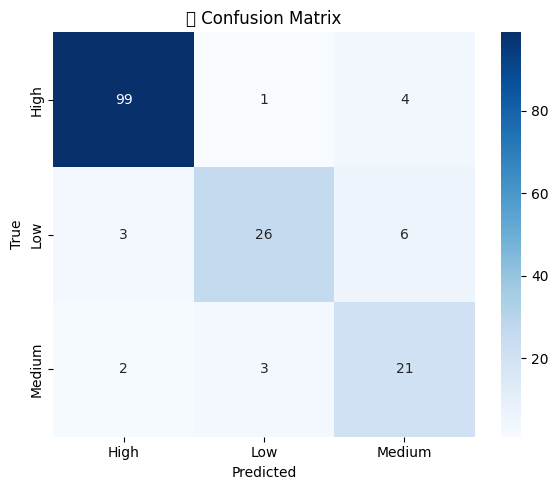

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Decode numeric labels back to strings
y_pred_labels = le.inverse_transform(y_pred)
y_true_labels = le.inverse_transform(y_true)

# Print classification report
print("📊 Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, digits=3))

# Optional: Display confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("🧠 Confusion Matrix")
plt.tight_layout()
plt.show()

